In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
def has_converged(x, size, epsilon):
    for i in range(0,size):
            if np.linalg.norm(x[-1:][0] - x[-(2+i):][0], np.inf) > epsilon:
                return False
    return True

In [3]:
def linear_proxies(x, y, z, eta, iters, d, epsilon):

    theta = [np.random.rand(d,1)]
    grad_l = [0]
    theta_average = [0]
    converged = False
    
    for t in range(1, iters):
        if converged:
            break
            
        costs = (np.matmul(x,theta[t-1])-z)*(1-2*y)
        
        prc_1 = LinearRegression(fit_intercept=False).fit(x,costs)
        prc_2 = LinearRegression(fit_intercept=False).fit(x,-costs)
        
        h_s_1 = prc_1.predict(x)
        h_s_2 = prc_2.predict(x)
        
        #Costs and h_s are the same, but only on first round I think. Check this.
        #Use matmul
        h_1 = (h_s_1 > 0)       
        h_2 = (h_s_2 > 0)
    
        if np.sum(h_s_1[h_1]) > np.sum(h_s_2[h_2]):
            h = h_1
        else:
            h = h_2

        h = h.astype(int)
        
        zhat = np.matmul(x,theta[t-1])        
        zhat_sum = np.sum(zhat)
        z_sum = np.sum(z)
        err_points = np.abs(h-y)
        
        [[err_cost]] = np.matmul((zhat-z).T,err_points)
        overall_diff = (zhat_sum/z_sum) - 1
        
        if np.abs(overall_diff) >= np.abs(err_cost):           
            penalty = np.sign(overall_diff) * np.sum(x, axis=0)/z_sum
            penalty = eta*penalty.reshape(-1,1)
        else:
            penalty = np.sign(err_cost) * np.matmul(np.transpose(x),err_points) 
            penalty = eta*penalty.reshape(-1,1)

        grad_l.append(penalty)
        new_theta = (theta[t-1] - grad_l[t])
        
        theta.append(new_theta)
        theta_average.append((t*theta_average[t-1]+theta[t])/(t+1))
        
        if t > 10:
            if has_converged(theta_average, 10, epsilon):
                converged = True
                    
    return theta, grad_l, theta_average[-1]   

In [4]:
def proxy_experiments(eta,T,trials,n,d,epsilon,unit=False):
    discrepancy_proxy = []
    discrepancy_total = []
    discrepancy_h = []
    intercept = np.ones(n).reshape(-1,1)
    
    for i in range(0,trials):
        y = np.round(np.random.rand(n,1))
        
        if unit:
            theta = np.random.rand(d,1)
            theta = theta/np.linalg.norm(theta)
            x = np.random.rand(n,d)
            
            for j in range(0,n):
                x[j,:] = x[j,:]/np.linalg.norm(x[j,:])
                
            zhat = np.matmul(x,theta)
            z = np.random.binomial(n=n,p=zhat)   
            
        else:
            z = np.round(np.random.rand(n,n))
            theta = np.random.rand(n,n)
            x = np.matmul(z, np.linalg.inv(theta))
            x = np.hstack((intercept, x))
            z = z[:,0].reshape(-1,1)

        coefficients, gradients, theta_average = linear_proxies(x, y, z, eta, T, d, epsilon)

        final_costs = (np.matmul(x,theta_average)-z)*(1-2*y)
        prc = LinearRegression(fit_intercept=False).fit(x,final_costs)  
        h_s = prc.predict(x)
        h_plus = (h_s > 0)
        h_minus = (h_s < 0)

        if np.sum(h_s[h_plus]) > -np.sum(h_s[h_minus]):
            h = h_plus
        else:
            h = h_minus

        h = h.astype(int)    
        zhat = np.matmul(x,theta_average)        
        zhat_sum = np.sum(zhat)
        z_sum = np.sum(z)
        err_points = np.abs(h-y)

        [[err_cost_z]] = np.matmul(z.T,err_points)
        [[err_cost_zhat]] = np.matmul(zhat.T,err_points)
        overall_diff = (zhat_sum/z_sum) - 1

        discrepancy_total.append(overall_diff)
        discrepancy_h.append(err_cost_zhat - err_cost_z)
        discrepancy_proxy.append(err_cost_zhat/zhat_sum - err_cost_z/z_sum)
        
    return discrepancy_total, discrepancy_h, discrepancy_proxy

In [ ]:
n = 1000
d = 100
trials = 100

d_proxy = []
d_total = []
d_h = []
etas = [0.01, 0.001, 0.0001]
iterations = [1000]
epsilon = 0.01

for iteration in iterations:
    for eta in etas:
        total, h, proxy = proxy_experiments(eta, iteration, trials, n, d, epsilon, unit = True)
        d_total.append(total)
        d_proxy.append(proxy)
        d_h.append(h)

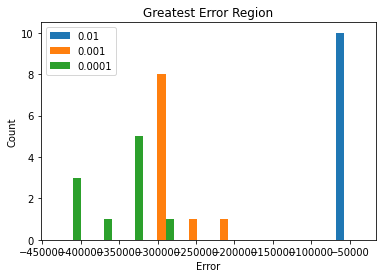

In [12]:
plt.hist(d_h)
plt.ylabel("Count")
plt.title("Greatest Error Region")
plt.xlabel("Error")
plt.legend(etas)

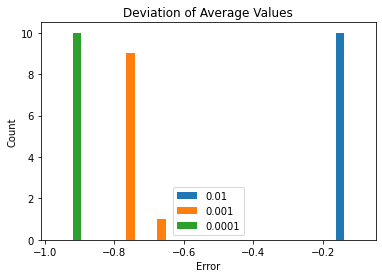

In [13]:
plt.hist(d_total)
plt.ylabel("Count")
plt.title("Deviation of Average Values")
plt.xlabel("Error")
plt.legend(etas)

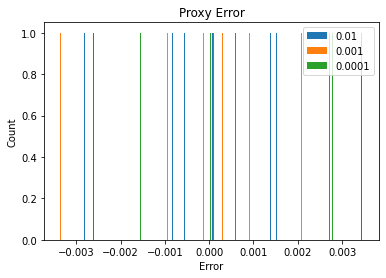

In [26]:
plt.hist(d_proxy, bins=100)
plt.ylabel("Count")
plt.title("Proxy Error")
plt.xlabel("Error")
plt.legend(etas)

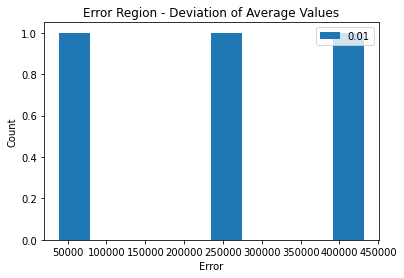

In [9]:
plt.hist(np.subtract(d_total,d_h))
plt.ylabel("Count")
plt.title("Error Region - Deviation of Average Values")
plt.xlabel("Error")
plt.legend(etas)

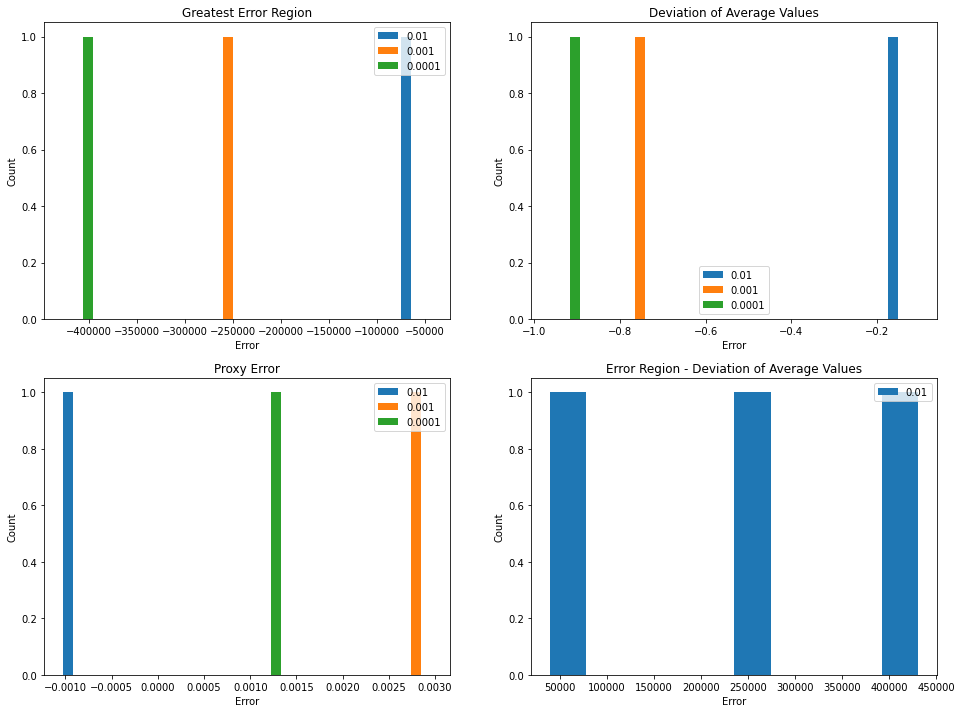

In [10]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.hist(d_h)
plt.ylabel("Count")
plt.title("Greatest Error Region")
plt.xlabel("Error")
plt.legend(etas)

plt.subplot(2,2,2)
plt.hist(d_total)
plt.ylabel("Count")
plt.title("Deviation of Average Values")
plt.xlabel("Error")
plt.legend(etas)

plt.subplot(2,2,3)
plt.hist(d_proxy)
plt.ylabel("Count")
plt.title("Proxy Error")
plt.xlabel("Error")
plt.legend(etas)

plt.subplot(2,2,4)
plt.hist(np.subtract(d_total,d_h))
plt.ylabel("Count")
plt.title("Error Region - Deviation of Average Values")
plt.xlabel("Error")
plt.legend(etas)